File always ends with two lines of white space

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import interpolate
import os

In [2]:
def list_txt():            # convenience function to return a list of .txt files and print their index in list
    files = os.listdir()   # return a list of files
    files = [file for file in files if file.endswith('.txt')]
    [print(i, file) for i, file in enumerate(files)]
    return files

In [3]:
files = list_txt()   # 0 is a multiplan, 1 is a plansum

0 MSC5-DVH_data_export_ALLNEW.txt
1 MSC5-DVH_data_export_PLANSUM.txt
2 MSC8-DVH_data_export_ALLNEW.txt
3 MSC8-DVH_data_export_PLANSUM.txt


In [4]:
def import_DVH(file):
    with open(file, "r") as file_:
        my_file = [line for line in file_.readlines()]  # my_file is a list representation of the text file
    file_.close()        

    file_len = len(my_file)     # number of lines in the file, addd the 1 for indexing 
    dvh_length = -1                # variable we will determine the length of the DVH
    file_type = 'undeclared'      # type we will determine if a plansum or multi_plan
    structures_indexs_list = []   # Get the structures
    plans_list = []               # Populate a list of the plans in the file 

    for i, line in enumerate(my_file):
        if line.startswith('Structure:'):
            structures_indexs_list.append(i)     # Get the index of all the structures

    plans_list = [my_file[i+2].split(':')[-1].strip('\n').strip()  for i in structures_indexs_list]   # Get the list of plans

    if len(plans_list) is 1:      # If only a single DVH in the file then it's a plansum
        file_type = 'plansum'
        dvh_length = file_len - 2 - (structures_indexs_list[0] + 19)     # end - start of dvh
        DVH_data = my_file[structures_indexs_list[0]+19:structures_indexs_list[0]+19+dvh_length]   # get that DVH data in a list
    
        Dose_Gy    = [float(line.strip('\n').split()[0]) for line in DVH_data]
        Ratio_pct  = [float(line.strip('\n').split()[1]) for line in DVH_data]
        df = pd.DataFrame(index=Dose_Gy, data=Ratio_pct, columns=[plans_list[0]])
    else:
        file_type = 'multi_plan' 
        dvh_length = file_len - 2 - (structures_indexs_list[-1] + 19)     # end - start of dvh
        df = pd.DataFrame()
        
        for i in range(len(plans_list)):
            # handel data indexing
            start = structures_indexs_list[i]+19  # first line of DVH data
            if i < len(structures_indexs_list)-1:
                end = structures_indexs_list[i+1]-2  # find the last line of the DVH from the next index, BEWARE THE +1
            else:
                end = len(my_file)-2
            DVH_data = my_file[start:end]  # get list with data

            # Get the DVH data into a dataframe 
            Dose_Gy    = [float(line.strip('\n').split()[0]) for line in DVH_data]

            if len(Dose_Gy) is 0:                                          # Check that DVH data is returned, if not skip
                print('skipping ' + plans_list[i] + ' as no DVH data')
    
            else:    
                Ratio_pct_raw = np.asarray([float(line.strip('\n').split()[2]) for line in DVH_data])  # convert to np for normalisation
                Ratio_pct_norm = 100.0*Ratio_pct_raw/Ratio_pct_raw.max()          # normalise
    
                df_temp = pd.DataFrame({'Dose_Gy' : Dose_Gy, plans_list[i]: Ratio_pct_norm}).astype(float) 
                df_temp.set_index(keys='Dose_Gy', drop=True, inplace=True)

                if df.empty:
                    df = df_temp           
                else:
                    df = pd.concat([df, df_temp], axis=1, join_axes=[df.index])
    
    return(df)

## Plot a single plan

In [5]:
file = files[1]
print(file)
data_df_single = import_DVH(file)

MSC5-DVH_data_export_PLANSUM.txt


Dataframe plot df.plot() at http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.plot.html
    
Alternative is to use plt.plot(df) at http://matplotlib.org/api/pyplot_api.html

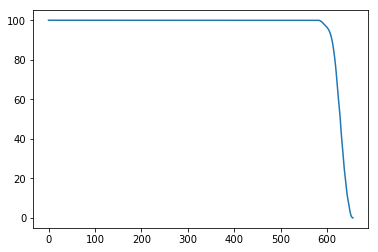

In [6]:
plt.plot(data_df_single)

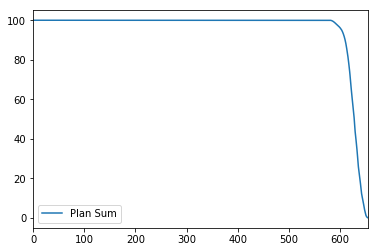

In [7]:
data_df_single.plot()

## Plot a multiplan

In [8]:
file = files[0]
print(file)
data_df = import_DVH(file)

MSC5-DVH_data_export_ALLNEW.txt
skipping Plan_0 as no DVH data


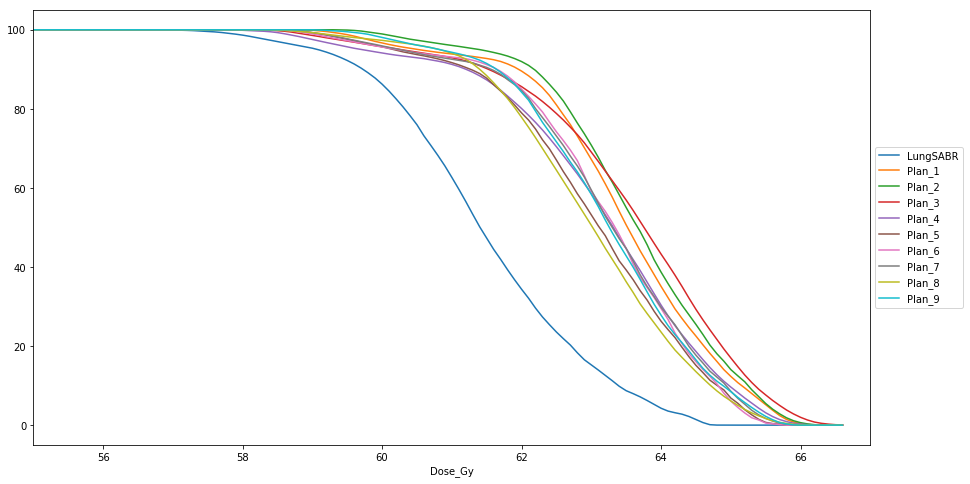

In [9]:
width = 15
height = 8
xmin = 55
xmax = 67

data_df.plot(figsize = [width,height],
             xlim=[xmin,xmax]
            ).legend(loc='center left', bbox_to_anchor=(1, 0.5));